# Exercises - GEO4902-02 - Data Assimilation

[Save as jupyter notebook, with your name in the filename, and upload on canvas]

# Exercise 02-02 -  Analyse the impact of the surface data assimilation 

In [1]:
# import python packages
import xarray as xr
import math
import numpy as np
import cartopy as cy
from matplotlib import pyplot as plt
from cmcrameri import cm


/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


#### Fill in the dates and hours for the exercise

In [2]:
year =  '2024'
day  =  '01'
month = '04'

hour_1  ='12'
hour_2  ='00'


url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_lagged_12_h_subset_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)


url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_lagged_12_h_subset_2_5km_'+year+month+day+'T'+hour_2+'Z.nc'
forecast_2 = xr.open_dataset(url)

### Find a specific point and plot the forecast. 
###### Note AROME Arctic is on an irregular grid, so the xarray.sel functionality does not work:

In [3]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    x=int(x)
    y=int(y)
   
    return (x,y)

In [4]:
[ix,jx] = findindex(forecast_1['latitude'],forecast_1['longitude'],78.24,15.46) # For example for Longyearbyen

/tmp/ipykernel_767014/4093572236.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/tmp/ipykernel_767014/4093572236.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


#### For example temperature

In [5]:
t2m_point_forecast_1 = forecast_1['air_temperature_2m'].isel(height1=0, y=ix, x=jx)
t2m_point_forecast_2 = forecast_2['air_temperature_2m'].isel(height1=0, y=ix, x=jx)

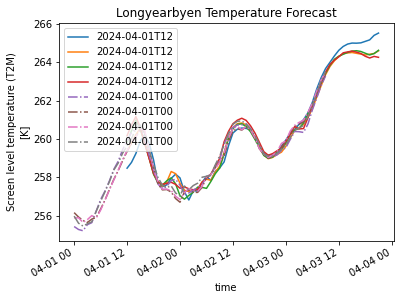

In [6]:
f, ax = plt.subplots()                              # define figure

t2m_point_forecast_1.plot.line(ax = ax, x='time', label=(np.datetime_as_string(t2m_point_forecast_1.time.isel(time=0), unit='h')), linestyle='-') 
t2m_point_forecast_2.plot.line(ax = ax, x='time', label=(np.datetime_as_string(t2m_point_forecast_2.time.isel(time=0), unit='h')), linestyle='-.')
plt.legend()
plt.title("Longyearbyen Temperature Forecast");

### Plot one forecast on a map

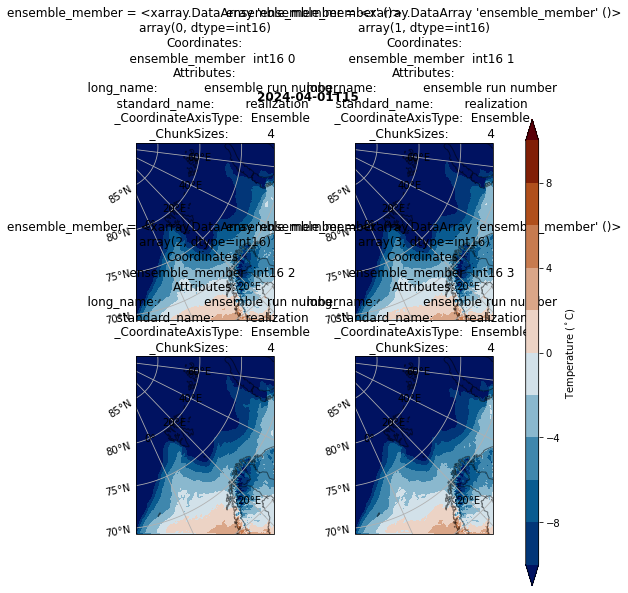

In [7]:
timestep_1=3

projection = cy.crs.LambertConformal(central_longitude =forecast_1.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =forecast_1.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = forecast_1.projection_lambert.standard_parallel)


f, axsm = plt.subplots(2,2, subplot_kw={'projection':projection}, figsize=[7.2, 7.2])

# plot cosmetics
for ax, em  in zip(axsm.flatten(), forecast_1['ensemble_member']):
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False


    cf = (forecast_1['air_temperature_2m'].isel(time=timestep_1, height1=0).sel(ensemble_member=em) - 273.15).plot.contourf(ax=ax, 
                                                                                               x='longitude', 
                                                                                               y='latitude', 
                                                                                               cmap=cm.vik, 
                                                                                               extend='both', 
                                                                                               transform=cy.crs.PlateCarree(),
                                                                                               levels=np.arange(-10,12,2),
                                                                                               add_colorbar=False,)
    ax.set(title ='ensemble_member = {}'.format(em))
    
cbaxes = f.add_axes([0.92, 0.025, 0.025, 0.9])
cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='vertical', extend='both',label='Temperature ($^\circ$C)')

f.suptitle(np.datetime_as_string(forecast_1.time.isel(time=timestep_1), unit='h'), fontweight="bold");